In [1]:
import numpy as np
import pandas as pd
import time
import re
import math
import sys
import torch
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount = False)

Mounted at /content/gdrive/


In [3]:
cd /content/gdrive/Shareddrives/Disk1/InfoPro-Pytorch/Experiments on CIFAR-SVHN-STL10

/content/gdrive/Shareddrives/Disk1/InfoPro-Pytorch/Experiments on CIFAR-SVHN-STL10


In [4]:
!nvidia-smi

Sat Nov 27 16:45:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
normalize = transforms.Normalize(mean=[x / 255 for x in [127.5, 127.5, 127.5]],
                                         std=[x / 255 for x in [127.5, 127.5, 127.5]])
transform_train = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((32,32)),                   
                    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                    normalize,
                    ])
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32,32)),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        
        ])#normalize
test_data=torchvision.datasets.FashionMNIST(root="/content/images", train=False, download=True, transform=transform_test)

In [ ]:
x, y = test_data[0:1]
x.size(), y

In [ ]:
img = x.permute(2, 1, 0)
img.size()

torch.Size([32, 32, 3])

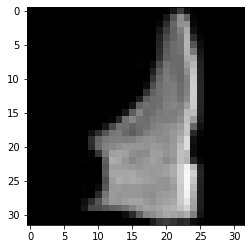

In [ ]:
plt.imshow(img)

In [ ]:
plt.imsave('/content/sample_data/original_img.png', img.numpy())

In [6]:
from networks.resnet_mixup import resnet16_chunk1, resnet16_chunk2
client = resnet16_chunk1(local_module_num=2,
                batch_size=8,
                image_size=32,
                balanced_memory=False,
                dataset='FMNIST',
                class_num=10,
                wide_list=(16, 16, 32, 64),
                dropout_rate=0.0,
                aux_net_config='1c2f',
                local_loss_mode='contrast',
                aux_net_widen=1,
                aux_net_feature_dim=128)
client=client.cuda()

In [ ]:
server = resnet16_chunk2(local_module_num=2,
                  batch_size=8,
                  image_size=32,
                  balanced_memory=False,
                  dataset='FMNIST',
                  class_num=10,
                  wide_list=(16, 16, 32, 64),
                  dropout_rate=0.0,
                  aux_net_config='1c2f',
                  local_loss_mode='contrast',
                  aux_net_widen=1,
                  aux_net_feature_dim=128, 
                  nworkers=15,
                  mixing = 'concat_batch')

server = server.cuda()

In [7]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [8]:
client.layer1.register_forward_hook(get_activation('layer1'))

In [ ]:
x_input = torch.unsqueeze(x, 0)
x_input = x_input.cuda()

In [ ]:
server_check_point_path = '/content/gdrive/Shareddrives/Disk1/InfoPro-Pytorch/Experiments on CIFAR-SVHN-STL10/MixUp_fmnist_resnet16_K_2_/multiworker/week15/worker_15/_normalised1_mixing_mode_concat_batch_local_label_size_100_batchsize_8_epochs_250_lr_0.001_lrpow_0.0_avg_frac_0.25_run_1_final_1k_pow_0.0_adam_average_multicast/central_checkpoint'
server_cp = torch.load(server_check_point_path + '/model_best.pth.tar')
server.load_state_dict(server_cp['state_dict'])

<All keys matched successfully>

In [9]:
testloader=torch.utils.data.DataLoader(test_data, batch_size=4)
batch=next(iter(testloader))

In [17]:
batch[0].size()

torch.Size([4, 3, 32, 32])

#### Const Lr, Frac 0.25

In [48]:
client_check_point_path = '/content/gdrive/Shareddrives/Disk1/InfoPro-Pytorch/Experiments on CIFAR-SVHN-STL10/MixUp_fmnist_resnet16_K_2_/multiworker/week15/worker_15/_normalised1_mixing_mode_concat_batch_local_label_size_100_batchsize_8_epochs_250_lr_0.001_lrpow_0.0_avg_frac_0.25_run_1_final_1k_pow_0.0_adam_average_multicast/checkpoint_0'
client_cp = torch.load(client_check_point_path+"/model_best.pth.tar")
client.load_state_dict(client_cp["state_dict"])

<All keys matched successfully>

In [30]:
client.eval()
client_output = client(batch[0].cuda())
print('Original Output Shape = ', client_output.size())
#client_output = nn.functional.interpolate(client_output, size=(4, 64, 16, 16), mode='bilinear', align_corners=True)
client_output = client_output.repeat(1, 2, 1, 1)
client_output.size()

Original Output Shape =  torch.Size([4, 32, 16, 16])


torch.Size([4, 64, 16, 16])

In [ ]:
client.eval()
client_output = client(x_input)
client_output.size()

torch.Size([1, 32, 16, 16])

In [ ]:
intermediate_act = activation['layer1']
intermediate_act.size()

torch.Size([4, 16, 32, 32])

In [ ]:
intermediate_img = intermediate_act[0].permute(2, 1, 0)
intermediate_img = intermediate_img.detach().cpu().numpy()
intermediate_img.shape

(32, 32, 16)

#added

In [ ]:
intermediate_img_batch=intermediate_img.reshape([-1,])

In [ ]:
!pip install lightning-bolts

In [13]:
from pl_bolts.models.autoencoders import VAE

vae = VAE(input_height=16)
print(VAE.pretrained_weights_available())
vae = vae.from_pretrained('cifar10-resnet18')
vae = vae.cuda()
vae.freeze()

['cifar10-resnet18', 'stl10-resnet18']


Downloading: "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/vae/vae-cifar10/checkpoints/epoch%3D89.ckpt" to /root/.cache/torch/hub/checkpoints/epoch%3D89.ckpt


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
vae.decoder.layer4

In [ ]:
partial_vae_list = []
for n,p in vae.decoder.named_parameters():
  print('Name -> ', n, 'Parameters -> ', p.size())
  # partial_vae_list.append()
  # if n == 'layer2.1.bn2.bias':
  #   break

In [32]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 3*recon_batch.size(2)*recon_batch.size(2)), x.view(-1, 3*recon_batch.size(2)*recon_batch.size(2)), reduction='sum')

    #KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE #+ KLD

In [36]:
sig_layer = nn.Sigmoid()

recon_batch = sig_layer(vae.decoder.conv1(vae.decoder.layer4((client_output.detach()))))
recon_batch = nn.functional.interpolate(recon_batch, (32,32), mode='bilinear', align_corners=True)
print("Reconstructed Size = ", recon_batch.size())
print('Original Size = ', batch[0].size())
loss = loss_function(recon_batch.cpu(), batch[0], 0, 0)
print(loss)
#save_image(comparison.cpu(),'/content/sample_data/reconstruction.png')

Reconstructed Size =  torch.Size([4, 3, 32, 32])
Original Size =  torch.Size([4, 3, 32, 32])
tensor(8880.3486)


In [49]:
loss = 0
for i, batch in enumerate(testloader):
  client.eval()
  client_output = client(batch[0].cuda())
  client_output = client_output.repeat(1, 4, 1, 1)
  recon_batch = sig_layer(vae.decoder.conv1(vae.decoder.layer4(vae.decoder.layer3(client_output.detach()))))
  recon_batch = nn.functional.interpolate(recon_batch, (32,32), mode='bilinear', align_corners=True)
  loss += loss_function(recon_batch.cpu(), batch[0], 0, 0)
  if (i+1)%1000 == 0:
    print(f'{i+1} samples done.')
print('Final Loss for Fraction 0.25 = ', loss/10000)

1000 samples done.
2000 samples done.
Final Loss for Fraction 0.25 =  tensor(2042.4712)


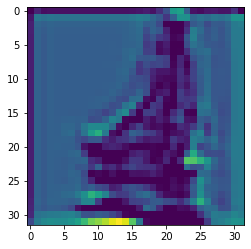

In [ ]:
plt.imshow(intermediate_img[:,:,0])

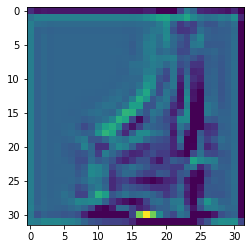

In [ ]:
plt.imshow(intermediate_img[:,:,2])

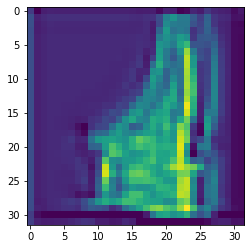

In [ ]:
plt.imshow(intermediate_img[:,:,4])

In [ ]:
plt.imsave('/content/sample_data/Const_LR_Frac_0.25.png', intermediate_img[:,:,4])

#### Const Lr, Frac 0.5

In [50]:
client_check_point_path = '/content/gdrive/Shareddrives/Disk1/InfoPro-Pytorch/Experiments on CIFAR-SVHN-STL10/MixUp_fmnist_resnet16_K_2_/multiworker/week15/worker_15/_normalised1_mixing_mode_concat_batch_local_label_size_100_batchsize_8_epochs_250_lr_0.001_lrpow_0.0_avg_frac_0.5_run_1_final_1k_pow_0.0_adam_average_multicast/checkpoint_0'
client_cp = torch.load(client_check_point_path+"/model_best.pth.tar")
client.load_state_dict(client_cp["state_dict"])

<All keys matched successfully>

In [51]:
loss = 0
for i, batch in enumerate(testloader):
  client.eval()
  client_output = client(batch[0].cuda())
  client_output = client_output.repeat(1, 4, 1, 1)
  recon_batch = sig_layer(vae.decoder.conv1(vae.decoder.layer4(vae.decoder.layer3(client_output.detach()))))
  recon_batch = nn.functional.interpolate(recon_batch, (32,32), mode='bilinear', align_corners=True)
  loss += loss_function(recon_batch.cpu(), batch[0], 0, 0)
  if (i+1)%1000 == 0:
    print(f'{i+1} samples done.')
print('Final Loss for Fraction 0.5 = ', loss/10000)

1000 samples done.
2000 samples done.
Final Loss for Fraction 0.5 =  tensor(2166.7087)


In [ ]:
client.eval()
client_output = client(x_input)
client_output.size()

torch.Size([1, 32, 16, 16])

In [ ]:
intermediate_act = activation['layer1']
intermediate_act.size()

torch.Size([1, 16, 32, 32])

In [ ]:
intermediate_img = intermediate_act[0].permute(2, 1, 0)
intermediate_img = intermediate_img.detach().cpu().numpy()
intermediate_img.shape

(32, 32, 16)

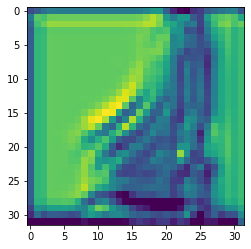

In [ ]:
plt.imshow(intermediate_img[:,:,0])

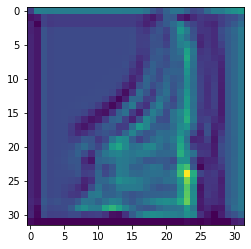

In [ ]:
plt.imshow(intermediate_img[:,:,12])

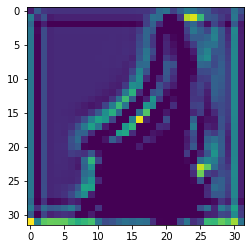

In [ ]:
plt.imshow(intermediate_img[:,:,4])

In [ ]:
plt.imsave('/content/sample_data/Const_LR_Frac_0.50.png', intermediate_img[:,:,12])

#### Const Lr, Frac 0.75

In [52]:
client_check_point_path = '/content/gdrive/Shareddrives/Disk1/InfoPro-Pytorch/Experiments on CIFAR-SVHN-STL10/MixUp_fmnist_resnet16_K_2_/multiworker/week15/worker_15/_normalised1_mixing_mode_concat_batch_local_label_size_100_batchsize_8_epochs_250_lr_0.001_lrpow_0.0_avg_frac_0.75_run_1_exp_1k_pow_1.0_adam_constant/checkpoint_0'
client_cp = torch.load(client_check_point_path+"/model_best.pth.tar")
client.load_state_dict(client_cp["state_dict"])

<All keys matched successfully>

In [53]:
loss = 0
for i, batch in enumerate(testloader):
  client.eval()
  client_output = client(batch[0].cuda())
  client_output = client_output.repeat(1, 4, 1, 1)
  recon_batch = sig_layer(vae.decoder.conv1(vae.decoder.layer4(vae.decoder.layer3(client_output.detach()))))
  recon_batch = nn.functional.interpolate(recon_batch, (32,32), mode='bilinear', align_corners=True)
  loss += loss_function(recon_batch.cpu(), batch[0], 0, 0)
  if (i+1)%1000 == 0:
    print(f'{i+1} samples done.')
print('Final Loss for Fraction 0.75 = ', loss/10000)

1000 samples done.
2000 samples done.
Final Loss for Fraction 0.75 =  tensor(2296.7769)


In [ ]:
client.eval()
client_output = client(x_input)
client_output.size()

torch.Size([1, 32, 16, 16])

In [ ]:
intermediate_act = activation['layer1']
intermediate_act.size()

torch.Size([1, 16, 32, 32])

In [ ]:
intermediate_img = intermediate_act[0].permute(2, 1, 0)
intermediate_img = intermediate_img.detach().cpu().numpy()
intermediate_img.shape

(32, 32, 16)

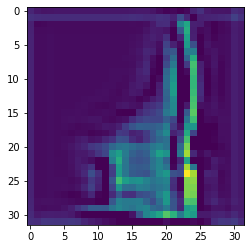

In [ ]:
plt.imshow(intermediate_img[:,:,0])

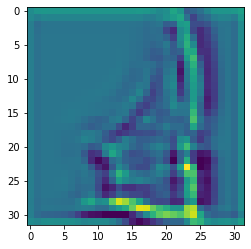

In [ ]:
plt.imshow(intermediate_img[:,:,2])

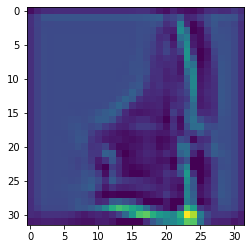

In [ ]:
plt.imshow(intermediate_img[:,:,4])

In [ ]:
plt.imsave('/content/sample_data/Const_LR_Frac_0.75.png', intermediate_img[:,:,4])

#### Const Lr, Frac 0.0

In [54]:
client_check_point_path = '/content/gdrive/Shareddrives/Disk1/InfoPro-Pytorch/Experiments on CIFAR-SVHN-STL10/MixUp_fmnist_resnet16_adam_K_2_/Intermediate Plots/worker_15/_normalised1_mixing_mode_concat_batch_local_label_size_100_batchsize_8_epochs_250_lr_0.001_lrpow_0.0_avg_frac_0.0_run_1_1k_adam_average_multicast/checkpoint_0'
client_cp = torch.load(client_check_point_path+"/model_best.pth.tar")
client.load_state_dict(client_cp["state_dict"])

<All keys matched successfully>

In [55]:
loss = 0
for i, batch in enumerate(testloader):
  client.eval()
  client_output = client(batch[0].cuda())
  client_output = client_output.repeat(1, 4, 1, 1)
  recon_batch = sig_layer(vae.decoder.conv1(vae.decoder.layer4(vae.decoder.layer3(client_output.detach()))))
  recon_batch = nn.functional.interpolate(recon_batch, (32,32), mode='bilinear', align_corners=True)
  loss += loss_function(recon_batch.cpu(), batch[0], 0, 0)
  if (i+1)%1000 == 0:
    print(f'{i+1} samples done.')
print('Final Loss for Fraction 0.0 = ', loss/10000)

1000 samples done.
2000 samples done.
Final Loss for Fraction 0.0 =  tensor(2153.7747)


In [ ]:
client.eval()
client_output = client(x_input)
client_output.size()

torch.Size([1, 32, 16, 16])

In [ ]:
intermediate_act = activation['layer1']
intermediate_act.size()

torch.Size([1, 16, 32, 32])

In [ ]:
intermediate_img = intermediate_act[0].permute(2, 1, 0)
intermediate_img = intermediate_img.detach().cpu().numpy()
intermediate_img.shape

(32, 32, 16)

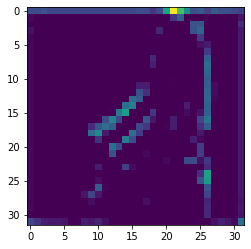

In [ ]:
plt.imshow(intermediate_img[:,:,0])

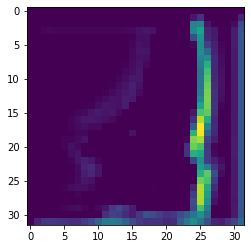

In [ ]:
plt.imshow(intermediate_img[:,:,2])

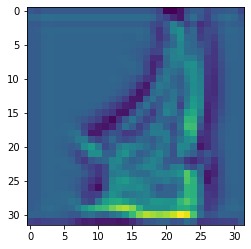

In [ ]:
plt.imshow(intermediate_img[:,:,4])

In [ ]:
plt.imsave('/content/sample_data/Const_LR_Frac_0.0.png', intermediate_img[:,:,4])

#### Const Lr, Frac 1.0

In [56]:
client_check_point_path = '/content/gdrive/Shareddrives/Disk1/InfoPro-Pytorch/Experiments on CIFAR-SVHN-STL10/MixUp_fmnist_resnet16_adam_K_2_/Intermediate Plots/worker_15/_normalised1_mixing_mode_concat_batch_local_label_size_100_batchsize_8_epochs_250_lr_0.001_lrpow_0.0_avg_frac_1.0_run_1_1k_adam_average_multicast/checkpoint_0'
client_cp = torch.load(client_check_point_path+"/model_best.pth.tar")
client.load_state_dict(client_cp["state_dict"])

<All keys matched successfully>

In [57]:
loss = 0
for i, batch in enumerate(testloader):
  client.eval()
  client_output = client(batch[0].cuda())
  client_output = client_output.repeat(1, 4, 1, 1)
  recon_batch = sig_layer(vae.decoder.conv1(vae.decoder.layer4(vae.decoder.layer3(client_output.detach()))))
  recon_batch = nn.functional.interpolate(recon_batch, (32,32), mode='bilinear', align_corners=True)
  loss += loss_function(recon_batch.cpu(), batch[0], 0, 0)
  if (i+1)%1000 == 0:
    print(f'{i+1} samples done.')
print('Final Loss for Fraction 1.0 = ', loss/10000)

1000 samples done.
2000 samples done.
Final Loss for Fraction 1.0 =  tensor(2759.2061)


In [ ]:
client.eval()
client_output = client(x_input)
client_output.size()

torch.Size([1, 32, 16, 16])

In [ ]:
intermediate_act = activation['layer1']
intermediate_act.size()

torch.Size([1, 16, 32, 32])

In [ ]:
intermediate_img = intermediate_act[0].permute(2, 1, 0)
intermediate_img = intermediate_img.detach().cpu().numpy()
intermediate_img.shape

(32, 32, 16)

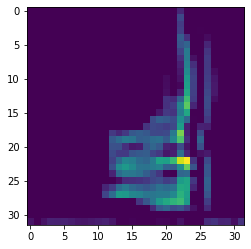

In [ ]:
plt.imshow(intermediate_img[:,:,0])

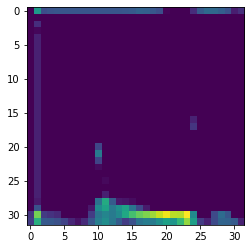

In [ ]:
plt.imshow(intermediate_img[:,:,2])

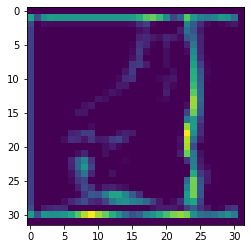

In [ ]:
plt.imshow(intermediate_img[:,:,4])

In [ ]:
plt.imsave('/content/sample_data/Const_LR_Frac_1.0.png', intermediate_img[:,:,4])  